## Analisi Esplorativa E-commerce Brasiliano (Olist)

Questo notebook presenta un'analisi completa del dataset Olist, con pulizia dati, feature engineering e analisi statistica esplorativa. 

## 0. Configurazione librerie

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pathlib import Path
import warnings
import config
from utils import *

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

%matplotlib inline

## 1. Configurazione dell'ambiente

Qui impostiamo alcune opzioni per rendere più leggibili i dati e uniformi i grafici che creeremo nel notebook.

In [ ]:
# Applichiamo le opzioni di visualizzazione definite in config.py
for option, value in config.PANDAS_DISPLAY_OPTIONS.items():
    pd.set_option(option, value)

# Impostiamo stile grafici e palette colori
plt.style.use(config.PLOT_STYLE)
sns.set_palette(config.PLOT_PALETTE)

# Log delle configurazioni
logger.info("=== Configurazione ambiente EDA Olist ===")
logger.info(f"Tasso conversione: 1 BRL = {config.BRL_TO_EUR} EUR")
logger.info(f"Cartella dati: {config.DATA_PATH}")
logger.info(f"Cartella output: {config.OUTPUT_DIR}")

# Verifica che la cartella dati esista
import os
if not os.path.exists(config.DATA_PATH):
    raise FileNotFoundError(f"Cartella dati non trovata: {config.DATA_PATH}")

2025-12-15 18:26:41 - INFO - === Configurazione ambiente EDA Olist ===
2025-12-15 18:26:41 - INFO - Tasso conversione: 1 BRL = 0.278 EUR
2025-12-15 18:26:41 - INFO - Cartella dati: g:\Il mio Drive\Documenti Andrea\Progetti\Brazilian E-Commerce\data
2025-12-15 18:26:41 - INFO - Cartella output: g:\Il mio Drive\Documenti Andrea\Progetti\Brazilian E-Commerce\outputs


## 2. Caricamento Dataset

Carichiamo tutti i file CSV definiti in `config.py` e facciamo un controllo rapido sulla qualità dei dati.
Per ogni dataset stampiamo le colonne e le prime righe per avere un’idea del contenuto.

In [13]:
logger.info("="*60)
logger.info("CARICAMENTO DATASET")
logger.info("="*60)

datasets = {}
for name, file in config.CSV_FILES.items():
    df = carica_dataset(file)
    if df is not None:
        datasets[name] = df
        try:
            analisi_qualita_dati(df, name)
        except Exception:
            # se la funzione di utilità fallisce non interrompiamo il caricamento
            logger.warning(f"analisi_qualita_dati fallita per {name}")
        print(f"\nFile: {file}  -> chiave: {name}")
        print(f"Colonne: {list(df.columns)}")
        print("Prime 3 righe:")
        print(df.head(3).to_string(index=False))
        print("-" * 40)
    else:
        logger.warning(f"Impossibile caricare: {file}")

2025-12-15 18:26:41 - INFO - ============================================================
2025-12-15 18:26:41 - INFO - CARICAMENTO DATASET
2025-12-15 18:26:41 - INFO - ============================================================
2025-12-15 18:26:41 - INFO - Caricato dataset da g:\Il mio Drive\Documenti Andrea\Progetti\Brazilian E-Commerce\data\olist_orders_dataset.csv con shape (99441, 8)
2025-12-15 18:26:41 - INFO - Valori mancanti (prime 5 colonne con più missing):
order_delivered_customer_date   0.03
order_delivered_carrier_date    0.02
order_approved_at               0.00
order_id                        0.00
order_purchase_timestamp        0.00
dtype: float64
2025-12-15 18:26:41 - INFO - orders: 99441 righe, 8 colonne



File: g:\Il mio Drive\Documenti Andrea\Progetti\Brazilian E-Commerce\data\olist_orders_dataset.csv  -> chiave: orders
Colonne: ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
Prime 3 righe:
                        order_id                      customer_id order_status order_purchase_timestamp   order_approved_at order_delivered_carrier_date order_delivered_customer_date order_estimated_delivery_date
e481f51cbdc54678b7cc49136f2d6af7 9ef432eb6251297304e76186b10a928d    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15          2017-10-04 19:55:00           2017-10-10 21:25:13           2017-10-18 00:00:00
53cdb2fc8bc7dce0b6741e2150273451 b0830fb4747a6c6d20dea0b8c802d7ef    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27          2018-07-26 14:31:00           2018-08-07 15:27:45           2018-08-13 00:00:00
47770eb9100c2d0c44946d9cf07

2025-12-15 18:26:42 - INFO - Caricato dataset da g:\Il mio Drive\Documenti Andrea\Progetti\Brazilian E-Commerce\data\olist_order_items_dataset.csv con shape (112650, 7)
2025-12-15 18:26:42 - INFO - Valori mancanti (prime 5 colonne con più missing):
order_id              0.00
order_item_id         0.00
product_id            0.00
seller_id             0.00
shipping_limit_date   0.00
dtype: float64
2025-12-15 18:26:42 - INFO - order_items: 112650 righe, 7 colonne



File: g:\Il mio Drive\Documenti Andrea\Progetti\Brazilian E-Commerce\data\olist_order_items_dataset.csv  -> chiave: order_items
Colonne: ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']
Prime 3 righe:
                        order_id  order_item_id                       product_id                        seller_id shipping_limit_date  price  freight_value
00010242fe8c5a6d1ba2dd792cb16214              1 4244733e06e7ecb4970a6e2683c13e61 48436dade18ac8b2bce089ec2a041202 2017-09-19 09:45:35  58.90          13.29
00018f77f2f0320c557190d7a144bdd3              1 e5f2d52b802189ee658865ca93d83a8f dd7ddc04e1b6c2c614352b383efe2d36 2017-05-03 11:05:13 239.90          19.93
000229ec398224ef6ca0657da4fc703e              1 c777355d18b72b67abbeef9df44fd0fd 5b51032eddd242adc84c38acab88f23d 2018-01-18 14:48:30 199.00          17.87
----------------------------------------


2025-12-15 18:26:42 - INFO - Caricato dataset da g:\Il mio Drive\Documenti Andrea\Progetti\Brazilian E-Commerce\data\olist_order_payments_dataset.csv con shape (103886, 5)
2025-12-15 18:26:42 - INFO - Valori mancanti (prime 5 colonne con più missing):
order_id               0.00
payment_sequential     0.00
payment_type           0.00
payment_installments   0.00
payment_value          0.00
dtype: float64
2025-12-15 18:26:42 - INFO - order_payments: 103886 righe, 5 colonne



File: g:\Il mio Drive\Documenti Andrea\Progetti\Brazilian E-Commerce\data\olist_order_payments_dataset.csv  -> chiave: order_payments
Colonne: ['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']
Prime 3 righe:
                        order_id  payment_sequential payment_type  payment_installments  payment_value
b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card                     8          99.33
a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card                     1          24.39
25e8ea4e93396b6fa0d3dd708e76c1bd                   1  credit_card                     1          65.71
----------------------------------------


2025-12-15 18:26:43 - INFO - Caricato dataset da g:\Il mio Drive\Documenti Andrea\Progetti\Brazilian E-Commerce\data\olist_order_reviews_dataset.csv con shape (99224, 7)
2025-12-15 18:26:43 - INFO - Valori mancanti (prime 5 colonne con più missing):
review_comment_title     0.88
review_comment_message   0.59
review_id                0.00
review_score             0.00
order_id                 0.00
dtype: float64
2025-12-15 18:26:43 - INFO - order_reviews: 99224 righe, 7 colonne



File: g:\Il mio Drive\Documenti Andrea\Progetti\Brazilian E-Commerce\data\olist_order_reviews_dataset.csv  -> chiave: order_reviews
Colonne: ['review_id', 'order_id', 'review_score', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp']
Prime 3 righe:
                       review_id                         order_id  review_score review_comment_title review_comment_message review_creation_date review_answer_timestamp
7bc2406110b926393aa56f80a40eba40 73fc7af87114b39712e6da79b0a377eb             4                  NaN                    NaN  2018-01-18 00:00:00     2018-01-18 21:46:59
80e641a11e56f04c1ad469d5645fdfde a548910a1c6147796b98fdf73dbeba33             5                  NaN                    NaN  2018-03-10 00:00:00     2018-03-11 03:05:13
228ce5500dc1d8e020d8d1322874b6f0 f9e4b658b201a9f2ecdecbb34bed034b             5                  NaN                    NaN  2018-02-17 00:00:00     2018-02-18 14:36:24
------------------------

2025-12-15 18:26:43 - INFO - Caricato dataset da g:\Il mio Drive\Documenti Andrea\Progetti\Brazilian E-Commerce\data\olist_customers_dataset.csv con shape (99441, 5)
2025-12-15 18:26:43 - INFO - Valori mancanti (prime 5 colonne con più missing):
customer_id                0.00
customer_unique_id         0.00
customer_zip_code_prefix   0.00
customer_city              0.00
customer_state             0.00
dtype: float64
2025-12-15 18:26:43 - INFO - customers: 99441 righe, 5 colonne
2025-12-15 18:26:43 - INFO - Caricato dataset da g:\Il mio Drive\Documenti Andrea\Progetti\Brazilian E-Commerce\data\olist_products_dataset.csv con shape (32951, 9)
2025-12-15 18:26:43 - INFO - Valori mancanti (prime 5 colonne con più missing):
product_category_name        0.02
product_description_lenght   0.02
product_name_lenght          0.02
product_photos_qty           0.02
product_weight_g             0.00
dtype: float64
2025-12-15 18:26:43 - INFO - products: 32951 righe, 9 colonne
2025-12-15 18:26:43 - IN


File: g:\Il mio Drive\Documenti Andrea\Progetti\Brazilian E-Commerce\data\olist_customers_dataset.csv  -> chiave: customers
Colonne: ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']
Prime 3 righe:
                     customer_id               customer_unique_id  customer_zip_code_prefix         customer_city customer_state
06b8999e2fba1a1fbc88172c00ba8bc7 861eff4711a542e4b93843c6dd7febb0                     14409                franca             SP
18955e83d337fd6b2def6b18a428ac77 290c77bc529b7ac935b93aa66c333dc3                      9790 sao bernardo do campo             SP
4e7b3e00288586ebd08712fdd0374a03 060e732b5b29e8181a18229c7b0b2b5e                      1151             sao paulo             SP
----------------------------------------

File: g:\Il mio Drive\Documenti Andrea\Progetti\Brazilian E-Commerce\data\olist_products_dataset.csv  -> chiave: products
Colonne: ['product_id', 'product_category_name', 'product_name_lenght'

2025-12-15 18:26:43 - INFO - Caricato dataset da g:\Il mio Drive\Documenti Andrea\Progetti\Brazilian E-Commerce\data\product_category_name_translation.csv con shape (71, 2)
2025-12-15 18:26:43 - INFO - Valori mancanti (prime 5 colonne con più missing):
product_category_name           0.00
product_category_name_english   0.00
dtype: float64
2025-12-15 18:26:43 - INFO - product_category: 71 righe, 2 colonne



File: g:\Il mio Drive\Documenti Andrea\Progetti\Brazilian E-Commerce\data\product_category_name_translation.csv  -> chiave: product_category
Colonne: ['product_category_name', 'product_category_name_english']
Prime 3 righe:
 product_category_name product_category_name_english
          beleza_saude                 health_beauty
informatica_acessorios         computers_accessories
            automotivo                          auto
----------------------------------------


## 3. Traduzione Dataset

Per facilitare l'analisi e la comprensione, traduciamo le colonne e alcuni valori chiave dei dataset in italiano.

In [14]:
logger.info("Traduzione colonne e dati in italiano...")
datasets_tradotti = {}
for name, df in datasets.items():
    traduzione_valori = {}
    if name == 'orders':
        traduzione_valori = {'order_status': config.TRADUZIONE_STATI_ORDINE}
    elif name == 'order_payments':
        traduzione_valori = {'payment_type': config.TRADUZIONE_PAGAMENTI}

    df_tradotto = traduci_dataset(df, config.TRADUZIONE_COLONNE, traduzione_valori)
    datasets_tradotti[name] = df_tradotto

customers_clean = datasets_tradotti.get('customers')
logger.info("Traduzione completata!")

# Stampa di esempio in modo sicuro (evita KeyError se 'orders' mancante)
if 'orders' in datasets_tradotti:
    print(f"\nEsempio - Colonne orders tradotte: {list(datasets_tradotti['orders'].columns)}")
else:
    print("\nEsempio - Colonne orders tradotte: (orders non presente nei dataset tradotti)")

2025-12-15 18:26:43 - INFO - Traduzione colonne e dati in italiano...
2025-12-15 18:26:43 - INFO - Traduzione completata!



Esempio - Colonne orders tradotte: ['id_ordine', 'id_cliente', 'stato_ordine', 'data_acquisto', 'data_approvazione', 'data_spedizione', 'data_consegna', 'data_consegna_stimata']


## 4. Conversione Valuta (BRL -> EUR)

Per rendere i valori monetari più comprensibili e confrontabili, convertiamo tutti i prezzi e i costi di spedizione dal Real Brasiliano (BRL) all'Euro (EUR), utilizzando il tasso di cambio definito nel file di configurazione.

In [15]:
def clean_currency_column(series):
    # Converte in stringa per gestire vari tipi di input
    series = series.astype(str)
    # Rimuove simboli di valuta, spazi e altri caratteri non numerici (tranne virgole e punti)
    series = series.str.replace(r'[^\d,.-]', '', regex=True)
    # Rimuove i punti usati come separatori di migliaia (formato brasiliano)
    series = series.str.replace('.', '', regex=False)
    # Sostituisce la virgola con il punto per i decimali (formato standard Python/Pandas)
    series = series.str.replace(',', '.', regex=False)
    return series

logger.info(f"Conversione valuta: 1 BRL = {config.BRL_TO_EUR} EUR")

if 'order_items' in datasets_tradotti:
    oi = datasets_tradotti['order_items']
    price_candidates = [c for c in ['prezzo','preco','price','preco_unitario','preco_unitario'] if c in oi.columns]
    freight_candidates = [c for c in ['costo_spedizione','freight_value','freight','custo_frete'] if c in oi.columns]

    if price_candidates:
        pcol = price_candidates[0]
        cleaned_price = clean_currency_column(oi[pcol])
        oi['prezzo_eur'] = pd.to_numeric(cleaned_price, errors='coerce') * config.BRL_TO_EUR
    else:
        oi['prezzo_eur'] = np.nan

    if freight_candidates:
        fcol = freight_candidates[0]
        cleaned_freight = clean_currency_column(oi[fcol])
        oi['costo_spedizione_eur'] = pd.to_numeric(cleaned_freight, errors='coerce') * config.BRL_TO_EUR
    else:
        oi['costo_spedizione_eur'] = 0.0

    oi['totale_articolo_eur'] = oi['prezzo_eur'].fillna(0) + oi['costo_spedizione_eur'].fillna(0)
    datasets_tradotti['order_items'] = oi

if 'order_payments' in datasets_tradotti:
    op = datasets_tradotti['order_payments']
    val_cols = [c for c in ['valore_pagamento','payment_value','payment_value_br'] if c in op.columns]
    if val_cols:
        cleaned_payment_value = clean_currency_column(op[val_cols[0]])
        op['valore_pagamento_eur'] = pd.to_numeric(cleaned_payment_value, errors='coerce') * config.BRL_TO_EUR
    else:
        op['valore_pagamento_eur'] = np.nan
    datasets_tradotti['order_payments'] = op

logger.info("Conversione valuta completata!")
try:
    logger.info(f" Prezzo medio EUR: {datasets_tradotti['order_items']['prezzo_eur'].mean():.2f}")
    logger.info(f" Valore pagamento medio EUR: {datasets_tradotti['order_payments']['valore_pagamento_eur'].mean():.2f}")
except Exception:
    pass

2025-12-15 18:26:43 - INFO - Conversione valuta: 1 BRL = 0.278 EUR


2025-12-15 18:26:44 - INFO - Conversione valuta completata!
2025-12-15 18:26:44 - INFO -  Prezzo medio EUR: 1096.09
2025-12-15 18:26:44 - INFO -  Valore pagamento medio EUR: 3788.91


## 5. Pulizia e Preprocessing Dati

In questa fase, ci assicuriamo che i dati siano pronti per l'analisi. Convertiamo le colonne che contengono date nel formato corretto, rimuoviamo eventuali righe duplicate e prepariamo i dataset per le successive aggregazioni.

In [16]:
logger.info("Pulizia e preprocessing dati...")
orders_clean = datasets_tradotti.get('orders', pd.DataFrame()).copy()
order_items_clean = datasets_tradotti.get('order_items', pd.DataFrame()).copy()
reviews_clean = datasets_tradotti.get('order_reviews', pd.DataFrame()).copy()

orders_clean = converti_colonne_data(orders_clean, ['data_acquisto', 'data_approvazione', 'data_spedizione', 'data_consegna', 'data_consegna_stimata'])
reviews_clean = converti_colonne_data(reviews_clean, ['data_creazione_recensione', 'data_risposta_recensione'])
order_items_clean = converti_colonne_data(order_items_clean, ['data_limite_spedizione'])

orders_clean = rimuovi_duplicati_avanzato(orders_clean, 'id_ordine')
order_items_clean = rimuovi_duplicati_avanzato(order_items_clean, ['id_ordine', 'id_articolo_ordine'])
reviews_clean = rimuovi_duplicati_avanzato(reviews_clean, 'id_recensione')

logger.info(f"✓ Orders puliti: {orders_clean.shape}")
logger.info(f"✓ Order items puliti: {order_items_clean.shape}")
logger.info(f"✓ Reviews puliti: {reviews_clean.shape}")


2025-12-15 18:26:44 - INFO - Pulizia e preprocessing dati...
2025-12-15 18:26:45 - INFO - Rimozione duplicati su id_ordine
2025-12-15 18:26:45 - INFO - Rimosse 0 righe duplicate
2025-12-15 18:26:45 - INFO - Rimozione duplicati su ['id_ordine', 'id_articolo_ordine']
2025-12-15 18:26:45 - INFO - Rimosse 0 righe duplicate
2025-12-15 18:26:45 - INFO - Rimozione duplicati su id_recensione
2025-12-15 18:26:45 - INFO - Rimosse 814 righe duplicate
2025-12-15 18:26:45 - INFO - ✓ Orders puliti: (99441, 8)
2025-12-15 18:26:45 - INFO - ✓ Order items puliti: (112650, 10)
2025-12-15 18:26:45 - INFO - ✓ Reviews puliti: (98410, 7)


## 6. Aggregazione Dati

Uniamo i dati provenienti da diverse fonti (pagamenti, articoli, recensioni, clienti) per creare un unico dataset a livello di ordine, con tutte le informazioni rilevanti in una sola riga.

In [17]:
logger.info("Aggregazione dati...")
payments_agg = aggrega_pagamenti(datasets_tradotti.get('order_payments', pd.DataFrame()))
items_agg = aggrega_order_items(order_items_clean)
reviews_agg = aggrega_reviews(reviews_clean)

# Merge
df_ordini = orders_clean.copy()
if payments_agg is not None:
    df_ordini = df_ordini.merge(payments_agg, on='id_ordine', how='left')
if items_agg is not None:
    df_ordini = df_ordini.merge(items_agg, on='id_ordine', how='left')
if reviews_agg is not None:
    df_ordini = df_ordini.merge(reviews_agg, on='id_ordine', how='left')
if customers_clean is not None:
    df_ordini = df_ordini.merge(customers_clean, on='id_cliente', how='left')

logger.info(f"✓ Dataset aggregato: {df_ordini.shape}")
logger.info(f"Colonne: {df_ordini.columns.tolist()}")


2025-12-15 18:26:45 - INFO - Aggregazione dati...
2025-12-15 18:26:45 - INFO - Pagamenti aggregati con shape (99440, 4)
2025-12-15 18:26:45 - INFO - Order_items aggregati con shape (98666, 7)
2025-12-15 18:26:46 - INFO - Reviews aggregate con shape (98167, 5)
2025-12-15 18:26:46 - INFO - ✓ Dataset aggregato: (99441, 25)
2025-12-15 18:26:46 - INFO - Colonne: ['id_ordine', 'id_cliente', 'stato_ordine', 'data_acquisto', 'data_approvazione', 'data_spedizione', 'data_consegna', 'data_consegna_stimata', 'valore_pagamento_brl', 'n_pagamenti', 'valore_pagamento_eur', 'n_articoli', 'totale_prezzo_brl', 'totale_spedizione_brl', 'totale_prezzo_eur', 'totale_spedizione_eur', 'totale_ordine_eur', 'punteggio_medio', 'n_recensioni', 'prima_recensione', 'ultima_risposta', 'id_cliente_univoco', 'cap_cliente', 'citta_cliente', 'stato_cliente']


## 7. Feature Engineering

In questa fase creiamo nuove variabili utili per l’analisi, come metriche temporali, categorie di valore degli ordini e una semplice segmentazione dei clienti basata su RFM (Recency, Frequency, Monetary).

In [18]:
logger.info("Feature engineering...")
df_ordini = calcola_metriche_temporali(df_ordini)
colonna_valore = 'totale_ordine_eur' if 'totale_ordine_eur' in df_ordini.columns else 'valore_pagamento_eur'
if colonna_valore in df_ordini.columns:
    df_ordini = crea_categorie_binning(df_ordini, colonna_valore, config.BINNING_VALORE_ORDINE['bins'], config.BINNING_VALORE_ORDINE['labels'], 'categoria_valore')
if 'giorni_consegna' in df_ordini.columns:
    df_ordini = crea_categorie_binning(df_ordini, 'giorni_consegna', config.BINNING_GIORNI_CONSEGNA['bins'], config.BINNING_GIORNI_CONSEGNA['labels'], 'categoria_consegna')

df_ordini, stats_segmentazione = segmenta_clienti(df_ordini)
logger.info(f"Feature engineering completato. Shape finale: {df_ordini.shape}")
logger.info(f"Nuove colonne: {[col for col in df_ordini.columns if col not in orders_clean.columns]}")


2025-12-15 18:26:46 - INFO - Feature engineering...
2025-12-15 18:26:56 - INFO - Segmentazione clienti (conteggio per segmento):
segmento
bronze    99441
2025-12-15 18:26:56 - INFO - Feature engineering completato. Shape finale: (99441, 30)
2025-12-15 18:26:56 - INFO - Nuove colonne: ['valore_pagamento_brl', 'n_pagamenti', 'valore_pagamento_eur', 'n_articoli', 'totale_prezzo_brl', 'totale_spedizione_brl', 'totale_prezzo_eur', 'totale_spedizione_eur', 'totale_ordine_eur', 'punteggio_medio', 'n_recensioni', 'prima_recensione', 'ultima_risposta', 'id_cliente_univoco', 'cap_cliente', 'citta_cliente', 'stato_cliente', 'giorni_consegna', 'ritardo_consegna', 'categoria_valore', 'categoria_consegna', 'segmento']


## 8. Salvataggio Dataset Finale

Salviamo il dataset finale, pulito e arricchito, in un file CSV per poterlo utilizzare facilmente nelle analisi successive o in strumenti di visualizzazione come Tableau.

In [19]:
output_file = 'dataset_ordini_pulito.csv'
salva_dataset(df_ordini, output_file)
stampa_statistiche_finali(df_ordini)
logger.info("="*60)
logger.info("ANALISI COMPLETATA CON SUCCESSO")
logger.info("="*60)


2025-12-15 18:27:02 - INFO - Dataset salvato in g:\Il mio Drive\Documenti Andrea\Progetti\Brazilian E-Commerce\outputs\dataset_ordini_pulito.csv
2025-12-15 18:27:02 - INFO - Statistiche per totale_ordine_eur:
2025-12-15 18:27:02 - INFO - count: 98666
2025-12-15 18:27:02 - INFO - mean: 1813.36
2025-12-15 18:27:02 - INFO - median: 911.01
2025-12-15 18:27:02 - INFO - std: 3308.10
2025-12-15 18:27:02 - INFO - min: 47.54
2025-12-15 18:27:02 - INFO - max: 133702.43
2025-12-15 18:27:02 - INFO - ============================================================
2025-12-15 18:27:02 - INFO - ANALISI COMPLETATA CON SUCCESSO
2025-12-15 18:27:02 - INFO - ============================================================


## 9. Analisi Statistica Semplificata

In questa sezione esploriamo i dati con statistiche di base e grafici semplici, per capire la qualità dei dati, le distribuzioni e le principali relazioni tra le variabili.

Percentuale di dati mancanti per colonna (solo > 0):
data_consegna        0.03
ritardo_consegna     0.03
categoria_consegna   0.03
giorni_consegna      0.03
data_spedizione      0.02
punteggio_medio      0.01
ultima_risposta      0.01
n_recensioni         0.01
prima_recensione     0.01
totale_ordine_eur    0.01


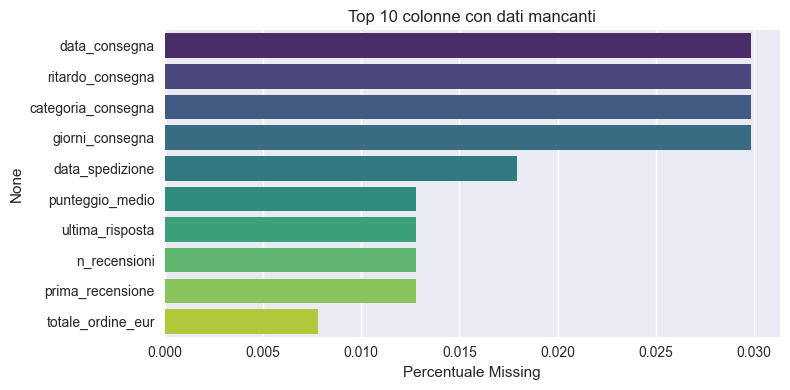

Statistiche descrittive base:
                          count     mean      std   min      25%      50%      75%        max
valore_pagamento_brl  99,440.00   160.99   221.95  0.00    62.01   105.29   176.97  13,664.08
n_pagamenti           99,440.00     1.04     0.38  1.00     1.00     1.00     1.00      29.00
valore_pagamento_eur  99,440.00 3,958.32 5,931.57  0.00 1,283.25 2,520.49 4,553.08 379,861.42
n_articoli            98,666.00     1.14     0.54  1.00     1.00     1.00     1.00      21.00
totale_prezzo_brl     98,666.00   137.75   210.65  0.85    45.90    86.90   149.90  13,440.00
totale_spedizione_brl 98,666.00    22.82    21.65  0.00    13.85    17.17    24.04   1,794.96
totale_prezzo_eur     98,666.00 1,251.43 3,125.97  6.12   166.80   375.30 1,109.22 127,877.22
totale_spedizione_eur 98,666.00   561.92   605.47  0.00   304.69   449.25   635.23  49,899.89
totale_ordine_eur     98,666.00 1,813.36 3,308.10 47.54   577.96   911.01 1,853.15 133,702.43
punteggio_medio       98,167.0

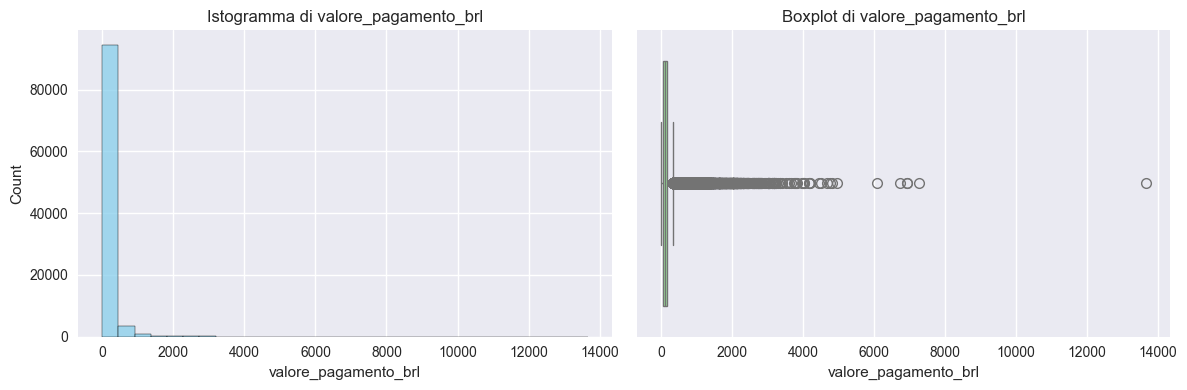

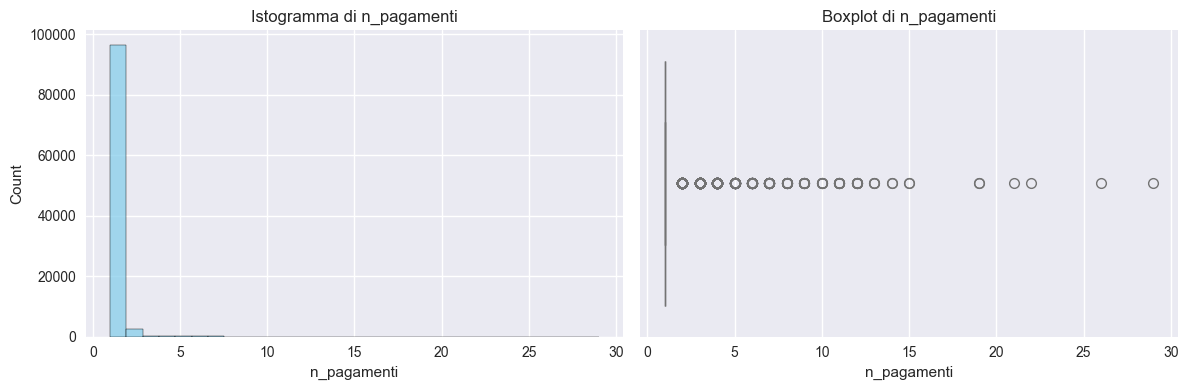

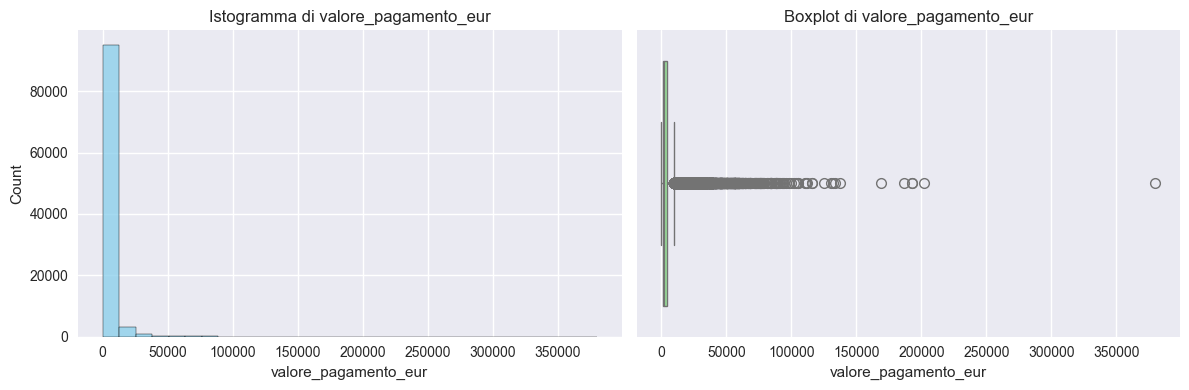

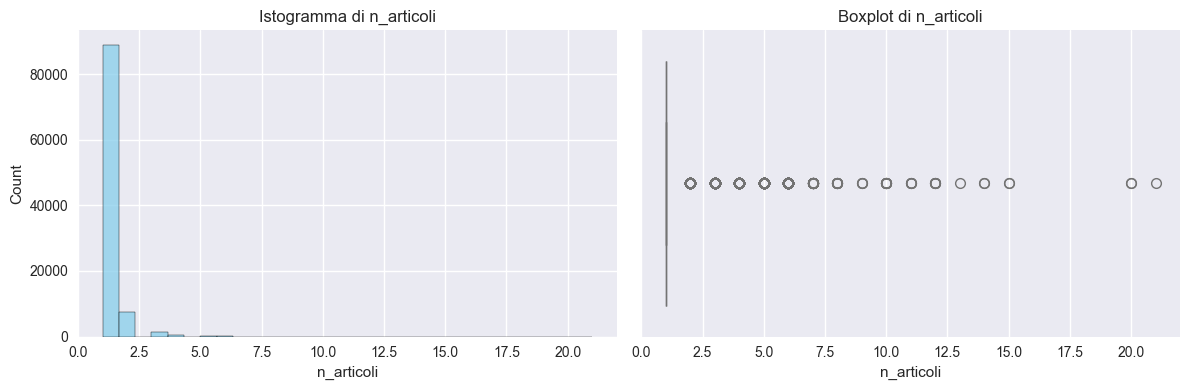

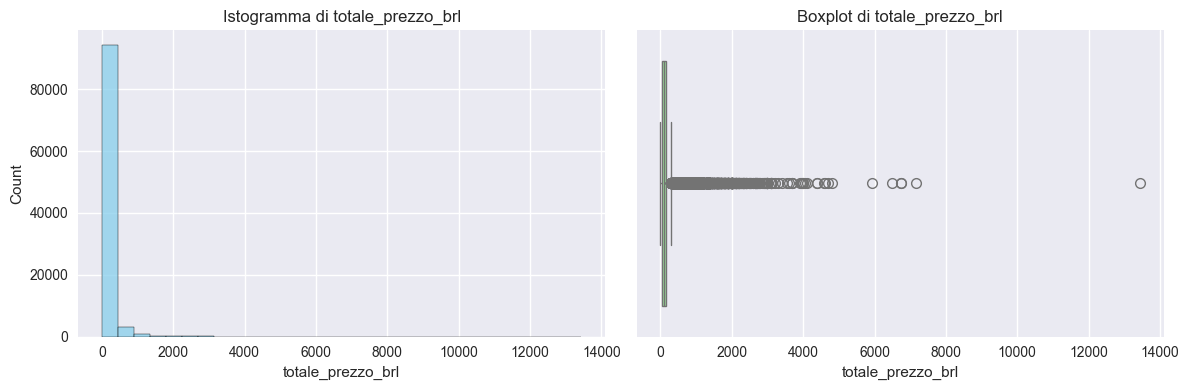

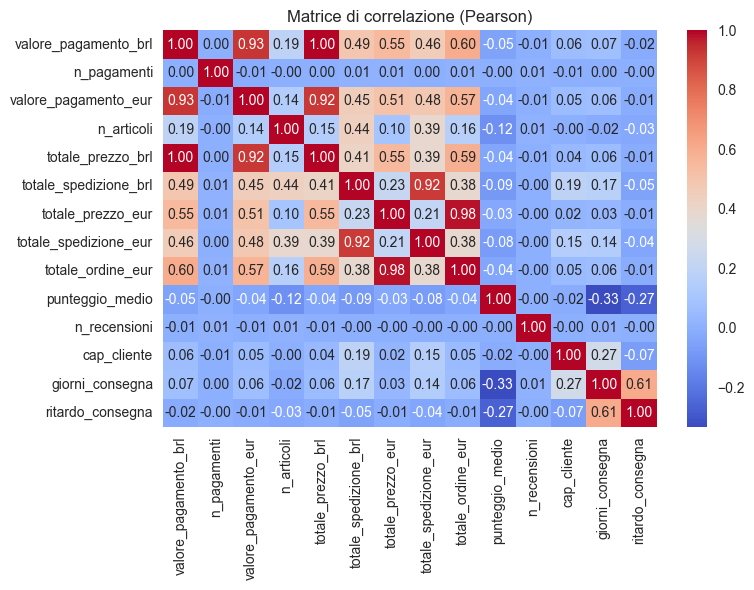

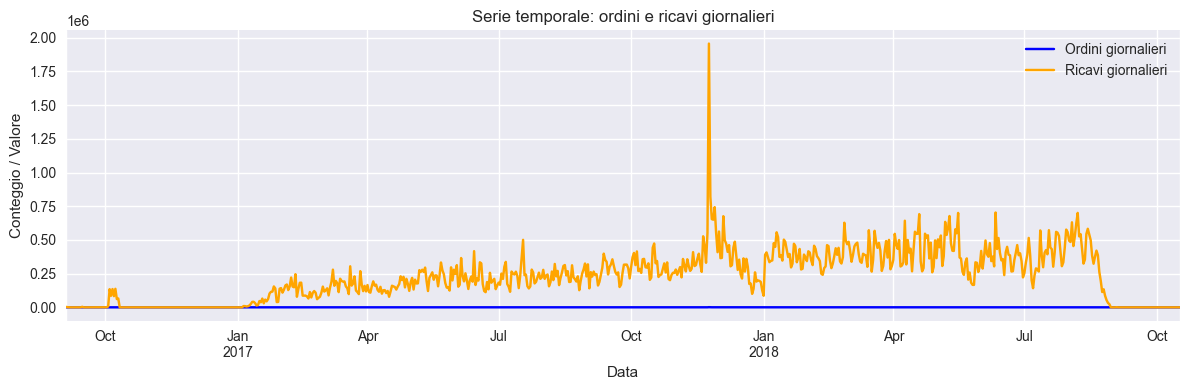

RFM - prime righe:
                         id_cliente  recency  frequency  monetary
0  00012a2ce6f8dcda20d059ce98491703      338          1    942.98
1  000161a058600d5901f007fab4c27140      459          1    500.40
2  0001fd6190edaaf884bcaf3d49edf079      597          1  5,432.68
3  0002414f95344307404f0ace7a26f1d5      428          1  1,235.43
4  000379cdec625522490c315e70c7a9fb      199          1    648.02


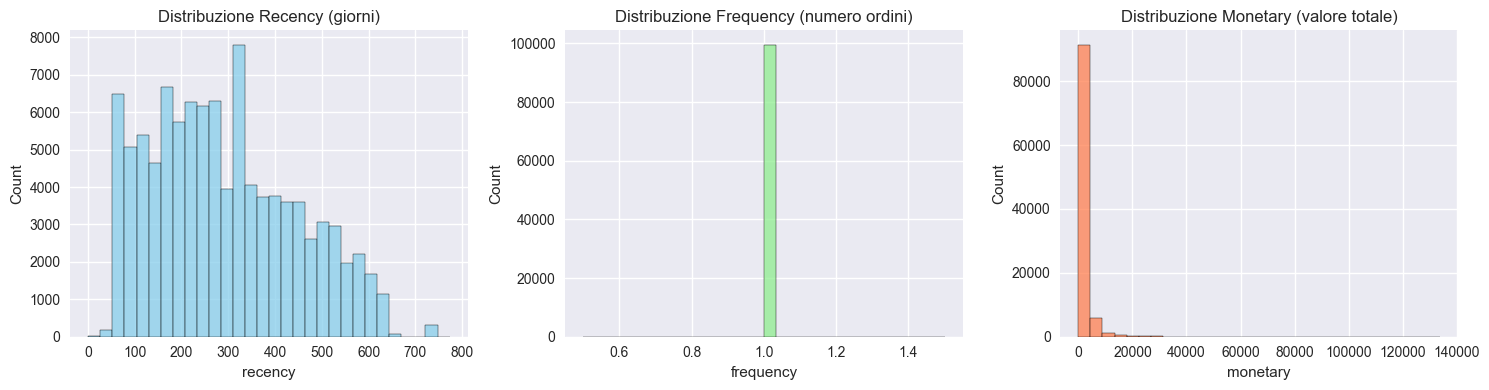

Colonna 'tipo_pagamento' o colonna valore ordine mancante per il test statistico.


In [20]:
import os
os.makedirs('outputs/figures', exist_ok=True)

# 9.1 Analisi Missing Data - percentuali e grafico semplice
missing_pct = df_ordini.isnull().mean().sort_values(ascending=False)
missing_pct = missing_pct[missing_pct > 0]
print("Percentuale di dati mancanti per colonna (solo > 0):")
print(missing_pct.head(10).to_string())

# Grafico a barre per le prime 10 colonne con più missing
if len(missing_pct) > 0:
    plt.figure(figsize=(8,4))
    sns.barplot(x=missing_pct.head(10).values, y=missing_pct.head(10).index, palette='viridis')
    plt.xlabel('Percentuale Missing')
    plt.title('Top 10 colonne con dati mancanti')
    plt.tight_layout()
    plt.savefig('outputs/figures/missing_data_simple.png')
    plt.show()
else:
    print("Nessun dato mancante rilevato.")

# %%
# 9.2 Statistiche descrittive base per colonne numeriche
numeric_cols = df_ordini.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = ['id_ordine', 'id_cliente', 'id_prodotto', 'id_venditore']
numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

if len(numeric_cols) == 0:
    print("Nessuna colonna numerica disponibile per analisi descrittiva.")
else:
    descr_stats = df_ordini[numeric_cols].describe().T[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
    print("Statistiche descrittive base:")
    print(descr_stats.head(10).to_string())

# %%
# 9.3 Distribuzioni semplici con istogrammi e boxplot
for col in numeric_cols[:5]:  # Limitiamo a prime 5 per semplicità
    data = df_ordini[col].dropna()
    if len(data) < 10:
        continue
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.histplot(data, bins=30, kde=False, color='skyblue')
    plt.title(f'Istogramma di {col}')
    plt.xlabel(col)

    plt.subplot(1,2,2)
    sns.boxplot(x=data, color='lightgreen')
    plt.title(f'Boxplot di {col}')

    plt.tight_layout()
    plt.savefig(f'outputs/figures/dist_{col}_simple.png')
    plt.show()

# %%
# 9.4 Matrice di correlazione semplice (Pearson) e heatmap
if len(numeric_cols) > 1:
    corr_matrix = df_ordini[numeric_cols].corr(method='pearson')
    plt.figure(figsize=(8,6))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
    plt.title('Matrice di correlazione (Pearson)')
    plt.tight_layout()
    plt.savefig('outputs/figures/corr_matrix_simple.png')
    plt.show()
else:
    print("Non ci sono abbastanza colonne numeriche per la correlazione.")

# %%
# 9.5 Analisi temporale base: ordini e ricavi giornalieri
if 'data_acquisto' in df_ordini.columns:
    ts = df_ordini.set_index('data_acquisto').resample('D').agg({'id_ordine':'count', colonna_valore:'sum'}).rename(columns={'id_ordine':'ordini'})
    ts.fillna(0, inplace=True)
    plt.figure(figsize=(12,4))
    ts['ordini'].plot(label='Ordini giornalieri', color='blue')
    if colonna_valore in ts.columns:
        ts[colonna_valore].plot(label='Ricavi giornalieri', color='orange')
    plt.legend()
    plt.title('Serie temporale: ordini e ricavi giornalieri')
    plt.xlabel('Data')
    plt.ylabel('Conteggio / Valore')
    plt.tight_layout()
    plt.savefig('outputs/figures/time_series_simple.png')
    plt.show()
else:
    print("Colonna 'data_acquisto' non presente per analisi temporale.")

# %%
# 9.6 Segmentazione clienti semplice con RFM
try:
    ref_date = df_ordini['data_acquisto'].max() + pd.Timedelta(days=1)
    rfm = df_ordini.groupby('id_cliente').agg(
        recency = ('data_acquisto', lambda x: (ref_date - x.max()).days),
        frequency = ('id_ordine', 'count'),
        monetary = (colonna_valore, 'sum')
    ).reset_index()
    print("RFM - prime righe:")
    print(rfm.head())

    # Visualizziamo la distribuzione di Recency, Frequency e Monetary
    fig, axes = plt.subplots(1, 3, figsize=(15,4))
    sns.histplot(rfm['recency'], bins=30, ax=axes[0], color='skyblue')
    axes[0].set_title('Distribuzione Recency (giorni)')
    sns.histplot(rfm['frequency'], bins=30, ax=axes[1], color='lightgreen')
    axes[1].set_title('Distribuzione Frequency (numero ordini)')
    sns.histplot(rfm['monetary'], bins=30, ax=axes[2], color='coral')
    axes[2].set_title('Distribuzione Monetary (valore totale)')
    plt.tight_layout()
    plt.savefig('outputs/figures/rfm_simple.png')
    plt.show()
except Exception as e:
    print("Errore nel calcolo RFM:", e)

# %%
# 9.7 Test statistici base: confronto medie con t-test (esempio semplice)
from scipy import stats

if 'tipo_pagamento' in df_ordini.columns and colonna_valore in df_ordini.columns:
    groups = df_ordini[[colonna_valore, 'tipo_pagamento']].dropna()
    unique_groups = groups['tipo_pagamento'].unique()
    if len(unique_groups) >= 2:
        group1 = groups[groups['tipo_pagamento'] == unique_groups[0]][colonna_valore]
        group2 = groups[groups['tipo_pagamento'] == unique_groups[1]][colonna_valore]
        t_stat, p_val = stats.ttest_ind(group1, group2, nan_policy='omit', equal_var=False)
        print(f"T-test tra '{unique_groups[0]}' e '{unique_groups[1]}': t={t_stat:.3f}, p={p_val:.3f}")
    else:
        print("Non ci sono almeno due gruppi di tipo_pagamento per il confronto.")
else:
    print("Colonna 'tipo_pagamento' o colonna valore ordine mancante per il test statistico.")

## Conclusioni

In questo notebook abbiamo:
- Pulito e tradotto i dati
- Convertito i prezzi in Euro
- Creato nuove variabili utili (metriche temporali, categorie di valore, RFM)
- Analizzato statisticamente i dati con grafici e tabelle
